**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

Question 1 Answer: 

In the CIFAR-10 dataset, there are 60000 images. The given ratio of the data split is 80% training, 10% validation and 10% test. This means there are 0.8 x 60000 = 48000 images in training, 0.1 x 60000 = 6000 images in validation and 0.1 x 60000 = 6000 images in testing. 

If in each step of gradient descent, you randomly select 32 examples from the training set, and since no example appears in more than one batch, it will take 48000/32 = 1500 iterations to go through the entire training set. 

One epoch is equal to going through the entire dataset once. This means that we need 30 epochs * 1500 iterations = 45000 iterations. Therefore, there are 45000 iterations in 30 epochs.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]


Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



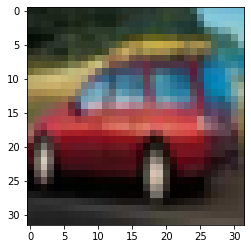

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

Question 2 Answer: 

In [ ]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  "PUT YOUR CODE HERE"
  # Input tensor
  N, C_in, H_in, W_in = my_image.shape

  # Kernal Weight
  k, _, _, C_out = initial_filter_weights.shape

  # Calculations
  H_out = H_in - k + 1
  W_out = W_in - k + 1

  # Initialize my conv output
  myConvOutput = jn.zeros((N, C_out, H_out, W_out))
  total = 0

  # For loops to generate output
  for n in range(N):
    for c in range(C_out):
      for h in range(H_out):
        for w in range(W_out):
          myConvOutput = myConvOutput.at[n, c, h, w].set(np.sum(my_image[n,:,h:h+k, w:w+k] * initial_filter_weights[:,:,:,c].transpose(2,0,1)))
  return myConvOutput

In [ ]:
print("Filter weights:", filter_weights)

# Run the function on my image and weights
myConvOutput = my_conv_net(my_image, filter_weights)

print("My Conv Output:", myConvOutput)
print("My Conv Output Shape:", np.shape(myConvOutput))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
My Conv Output: [[[[-0.10271907 -0.10010862 -0.09076816 ... -0.7420423  -0.7391249
    -0.7374623 ]
   [-0.12882358 -0.11180527 -0.11687266 ... -0.7310544  -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.71560836]
   ...
   [-0.11485984 -0.10963892 -0.10963892 ... -0.11178758 -0.11439803
    -0.12222938]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.12745032 -0.12483985
    -0.12483985]
   [-0.08614486 -0.08353443 -0.08614486 ... -0.16399662 -0.16138616
    -0.15355483]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.7525325   0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.7793448   0.76264036
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.7925384   0.7784524
     0.775332  ]
   ...
   [ 0.20083013  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   

In [ ]:
# Get the absolute mean difference between my output and Conv2d
print(np.mean(np.absolute((myConvOutput - Conv2d(my_image)))))

7.658422e-09


My convolution output only differs from Conv2d by 7.658422e-09 and has the same output shape. Therefore, I can confirm that it performs the same function as Objax's.

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
myConvOutput.mean((2,3))

DeviceArray([[-0.14000711,  0.35388902]], dtype=float32)

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



Question 3 Answer: 

In [ ]:
#PUT YOUR CODE HERE

# Get my rearranged output and put it into a Linear Layer
X = myConvOutput.mean((2,3))
N = X.shape[1]

# Objax's Linear Layer
Linear_Layer = objax.nn.Linear(N,1)
Y_Value = Linear_Layer(X)

# Implementing the Linear Layer manually
myLinearLayerValue = np.dot(X, Linear_Layer.w.value) + Linear_Layer.b.value

In [ ]:
# Compare the values
print("Objax's Linear Layer Value = ", Y_Value, "Manually Implemented Linear Layer Value = ", myLinearLayerValue)

Objax's Linear Layer Value =  [[-0.09563078]] Manually Implemented Linear Layer Value =  [[-0.09563078]]


Question 4 Answer: 

The training set is the larger subset of the dataset that is used for training the models with.

The validation set is smaller subset of the dataset that is used for the evaluation of the models in order to perform model selection.

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv = objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params - grad * lr)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.02
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

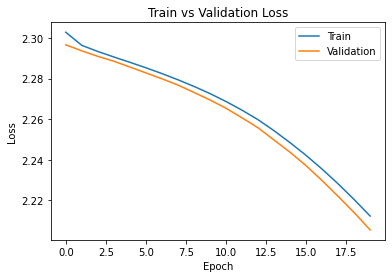

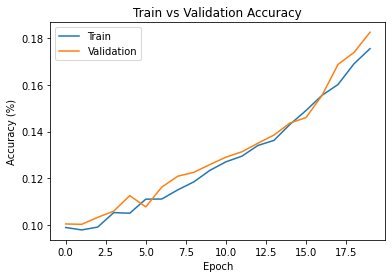

In [ ]:
train()

Question 4 Answer:

Hyperparameters are parameters that can't be learned using gradient descent and the user must select/specify prior to the training of the model.

The initially chosen hyperparameters will often not generate the best results in accuracy. Therefore, we must tune all of the hyperparameters gradually before arriving on the final hyperparameters. This tuning process occurs on the validation set where the goal is to attain the highest validation accuracy and lowest validation loss. That happens after the model was trained on the training set. Finally, the accuracy on the test set displays the overall generalizability of the model. This means that it can only be evaluated once with our final model with the finalized hyperparameters. Testing on the test set is only done once.

Follow the assignment handout for questions to be answered in this part of the assignment.

Question 5 Answer:

The 4 hyperparameters that I will be tuning are: batch size, learning rate, number of convolutional layers, and activation function.

The different hyperparameter settings are:

H1 = {16, 0.01, 2, sigmoid}

H2 = {32, 0.005, 3, ReLU}

Question 6 Answer:

In [ ]:
# Model 1 with H1 Hyperparameters (H1 = {16, 0.01, 2, sigmoid})
class M1ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    # 2 convolutional layers
    # sigmoid activation function
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.sigmoid])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.sigmoid])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M1ConvNet()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv = objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params - grad * lr)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
# Batch size = 16, LR = 0.01
def train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.13 Validation Accuracy 10.22
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.10 Validation Accuracy 15.20
Epoch 0003  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 13.40 Validation Accuracy 16.92
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 14.30 Validation Accuracy 10.42
Epoch 0005  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 16.20 Validation Accuracy 14.82
Epoch 0006  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 16.99 Validation Accuracy 15.07
Epoch 0007  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 17.94 Validation Accuracy 16.82
Epoch 0008  Training Loss 2.23 Validation Loss 2.21 Training Accuracy 18.64 Validation Accuracy 17.97
Epoch 0009  Training Loss 2.20 Validation Loss 2.18 Training Accuracy 19.34 Validation Accuracy 18.33
Epoch 0010  Training Loss 2.17 Validation Loss 2.15 Training Accuracy 20.32 Valida

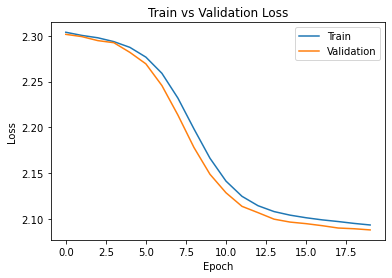

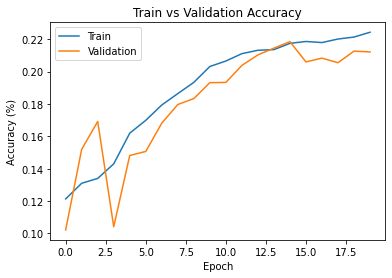

In [ ]:
train()

In [ ]:
# Model 2 with H2 Hyperparameters (H2 = {32, 0.005, 3, ReLU})
class M2ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    # 3 convolutional layers
    # ReLU activation function
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M2ConvNet()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv = objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params - grad * lr)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
# Batch size = 32, LR = 0.005
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.005):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.28 Validation Loss 2.26 Training Accuracy 15.57 Validation Accuracy 18.15
Epoch 0002  Training Loss 2.21 Validation Loss 2.15 Training Accuracy 19.11 Validation Accuracy 19.13
Epoch 0003  Training Loss 2.11 Validation Loss 2.09 Training Accuracy 21.73 Validation Accuracy 21.87
Epoch 0004  Training Loss 2.08 Validation Loss 2.07 Training Accuracy 23.15 Validation Accuracy 21.92
Epoch 0005  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 23.83 Validation Accuracy 22.73
Epoch 0006  Training Loss 2.06 Validation Loss 2.06 Training Accuracy 24.51 Validation Accuracy 23.67
Epoch 0007  Training Loss 2.05 Validation Loss 2.04 Training Accuracy 25.62 Validation Accuracy 25.55
Epoch 0008  Training Loss 2.03 Validation Loss 2.04 Training Accuracy 26.81 Validation Accuracy 24.75
Epoch 0009  Training Loss 2.02 Validation Loss 2.01 Training Accuracy 27.53 Validation Accuracy 26.52
Epoch 0010  Training Loss 2.00 Validation Loss 1.99 Training Accuracy 28.99 Valida

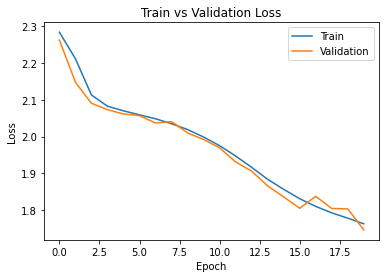

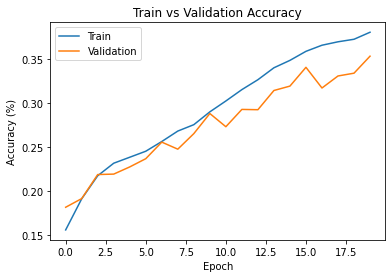

In [ ]:
train()

The best validation
accuracy as well as the corresponding epoch for which this occurs for the Base Model and my two additional models:

Base Model: 18.27% validation accuracy at Epoch 20

M1ConvNet Model: 21.85% validation accuracy at Epoch 15

M2ConvNet Model: 35.32% validation accuracy at Epoch 20

Model 2 performs the best in terms of validation accuracy. 

Question 7 Answer:

The model I would pick for the final model is definitely model 2. Because it has the best validation accuracy, I would beieve it would perform the best out of all the models on the test data.

In [ ]:
# Test on the test data
meanTestLoss = float(loss_function(X_test, Y_test)) 
testPrediction = predict(X_test).argmax(1)
testingAccuracy = ((np.array(testPrediction).flatten() == Y_test).sum())/X_test.shape[0]

print('Test Set Accuracy: %.2f' % (testingAccuracy * 100))
print('Mean Test Loss: %.2f' % (meanTestLoss))

Test Set Accuracy: 36.03
Mean Test Loss: 1.75


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [ ]:
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import TensorBoard

In [ ]:
# For part 3, I am using the rock_paper_scissors dataset

# Hyperparameters initializtion
batch_size = 32
num_classes = 3
epochs = 20

# Function to preprocess the data
def preprocess_image(image, label):
    # convert [0, 255] range integers to [0, 1] range floats
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

# Loading in training and testing sets
trainingSet, trainingInfo = tfds.load("rock_paper_scissors", with_info=True, split="train", as_supervised=True)
testingSet, testingIinfo = tfds.load("rock_paper_scissors", with_info=True, split="test", as_supervised=True)

# Preprocess the shuffled images and split by batch
trainingSet = trainingSet.repeat(100).shuffle(1024).map(preprocess_image).batch(batch_size)
validationSet = trainingSet.repeat(10).shuffle(1024).map(preprocess_image).batch(batch_size)
testingSet = testingSet.repeat(10).shuffle(1024).map(preprocess_image).batch(batch_size)

In [ ]:
# As the base model, I am using the following model
def initialize_model():
    model = Sequential()
    model.add(AveragePooling2D(3, 3, input_shape=(300, 300, 3)))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Conv2D(32, 3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Use Adam Optimizer
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [ ]:
model = initialize_model()

# print the summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 100, 100, 3)      0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0

##**Problem 4. Open-Ended Exploration**

See the handout for instructions.

I will be answering question 4.1 Additional hyperparameter tuning on top of Part 2 code.

While working with hyperparameter tuning in that part, I didn't modify these hyperparameter: number of output channels in convolution layer 1 and epoch count

I will take the other hyperparameters from my M2ConvNet Model 2 and modify these hyperparameter and document the outcome.

Since I believe that Model 2 from part 2 didn't train for long enough, as the validation accuracy was increasing until the last epoch. Hoping that increasing the number of epochs will lead to a much larger validation accuracy and lower loss.

In [ ]:
# Model 3 with H2 Hyperparameters (H2 = {32, 0.005, 3, ReLU}) 
# Additionally, now the  number of output channels in convolution layer 1 = 24 instead of 16

class M3ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    # 3 convolutional layers
    # ReLU activation function
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 24, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(24, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M3ConvNet()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv = objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params - grad * lr)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
# Batch size = 32, LR = 0.005
# Additionally, now I will do 50 epochs instead of 20

def train(EPOCHS = 50, BATCH = 32, LEARNING_RATE = 0.005):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          #PUT YOUR CODE HERE#
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.29 Validation Loss 2.27 Training Accuracy 14.07 Validation Accuracy 16.08
Epoch 0002  Training Loss 2.21 Validation Loss 2.15 Training Accuracy 18.31 Validation Accuracy 19.73
Epoch 0003  Training Loss 2.11 Validation Loss 2.09 Training Accuracy 21.17 Validation Accuracy 21.83
Epoch 0004  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 22.88 Validation Accuracy 22.53
Epoch 0005  Training Loss 2.08 Validation Loss 2.06 Training Accuracy 23.43 Validation Accuracy 22.83
Epoch 0006  Training Loss 2.06 Validation Loss 2.05 Training Accuracy 24.51 Validation Accuracy 24.22
Epoch 0007  Training Loss 2.04 Validation Loss 2.03 Training Accuracy 26.01 Validation Accuracy 25.83
Epoch 0008  Training Loss 2.01 Validation Loss 1.98 Training Accuracy 28.27 Validation Accuracy 28.32
Epoch 0009  Training Loss 1.97 Validation Loss 1.95 Training Accuracy 29.92 Validation Accuracy 27.97
Epoch 0010  Training Loss 1.93 Validation Loss 1.91 Training Accuracy 30.82 Valida

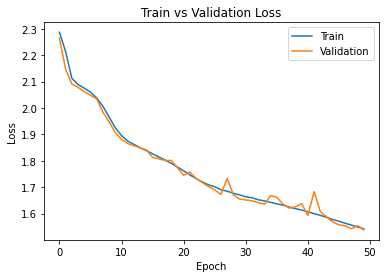

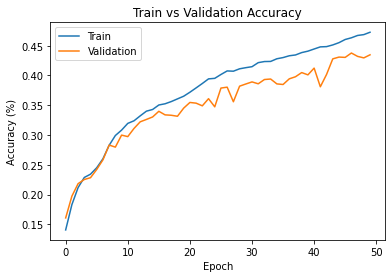

In [ ]:
train()

Final comparisons:

Base Model: 18.27% validation accuracy at Epoch 20

M1ConvNet Model: 21.85% validation accuracy at Epoch 15

M2ConvNet Model: 35.32% validation accuracy at Epoch 20

M2ConvNet Model: 35.32% validation accuracy at Epoch 20

M3ConvNet Model: 43.77% validation accuracy at Epoch 47

Model 3 performs the best in terms of validation accuracy.

The model I would pick for the final model is now definitely model 3. Because it has the best validation accuracy, I would beieve it would perform the best out of all the models on the test data.

In [ ]:
# Test on the test data
meanTestLoss = float(loss_function(X_test, Y_test)) 
testPrediction = predict(X_test).argmax(1)
testingAccuracy = ((np.array(testPrediction).flatten() == Y_test).sum())/X_test.shape[0]

print('Test Set Accuracy: %.2f' % (testingAccuracy * 100))
print('Mean Test Loss: %.2f' % (meanTestLoss))

Test Set Accuracy: 43.22
Mean Test Loss: 1.54
